Data taken from http://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html
More information: http://physics.nist.gov/PhysRefData/XrayMassCoef/chap3.html

In [1]:
from __future__ import print_function

In [2]:
import matplotlib
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import Core.system_of_units as units

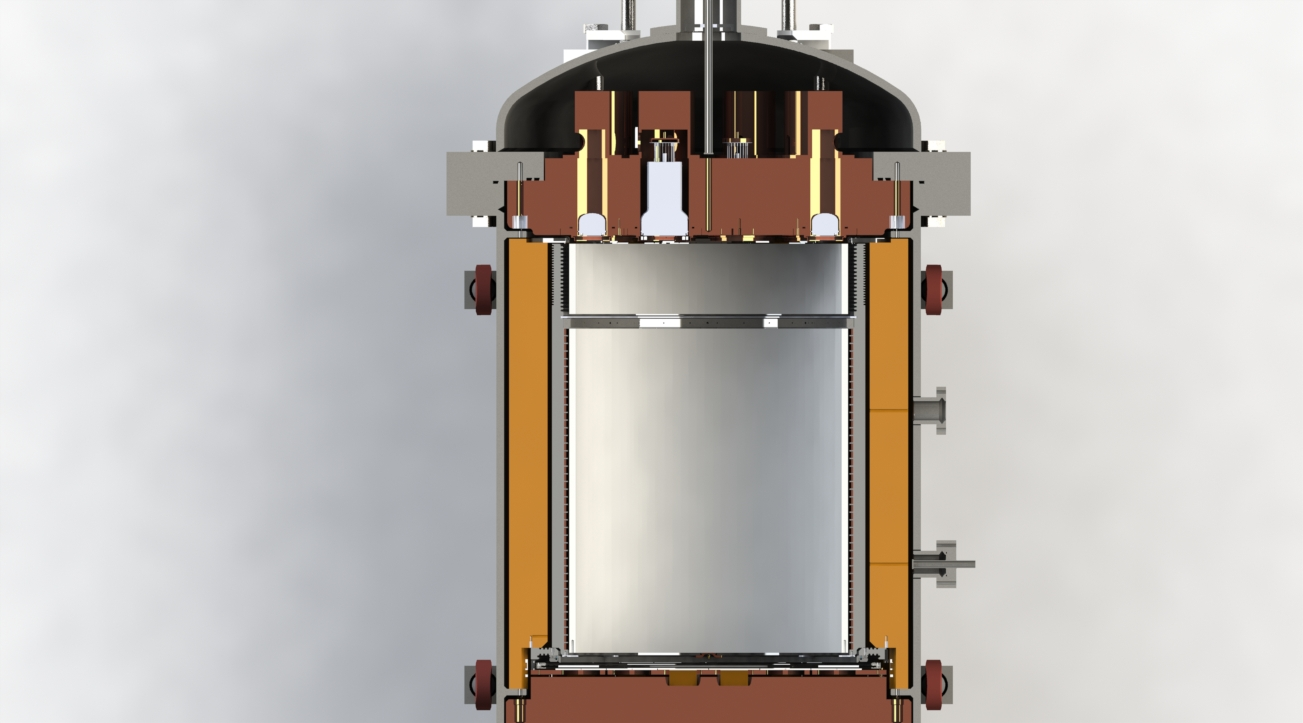

In [3]:
Image(filename='NEW_cut_top1.jpg') 

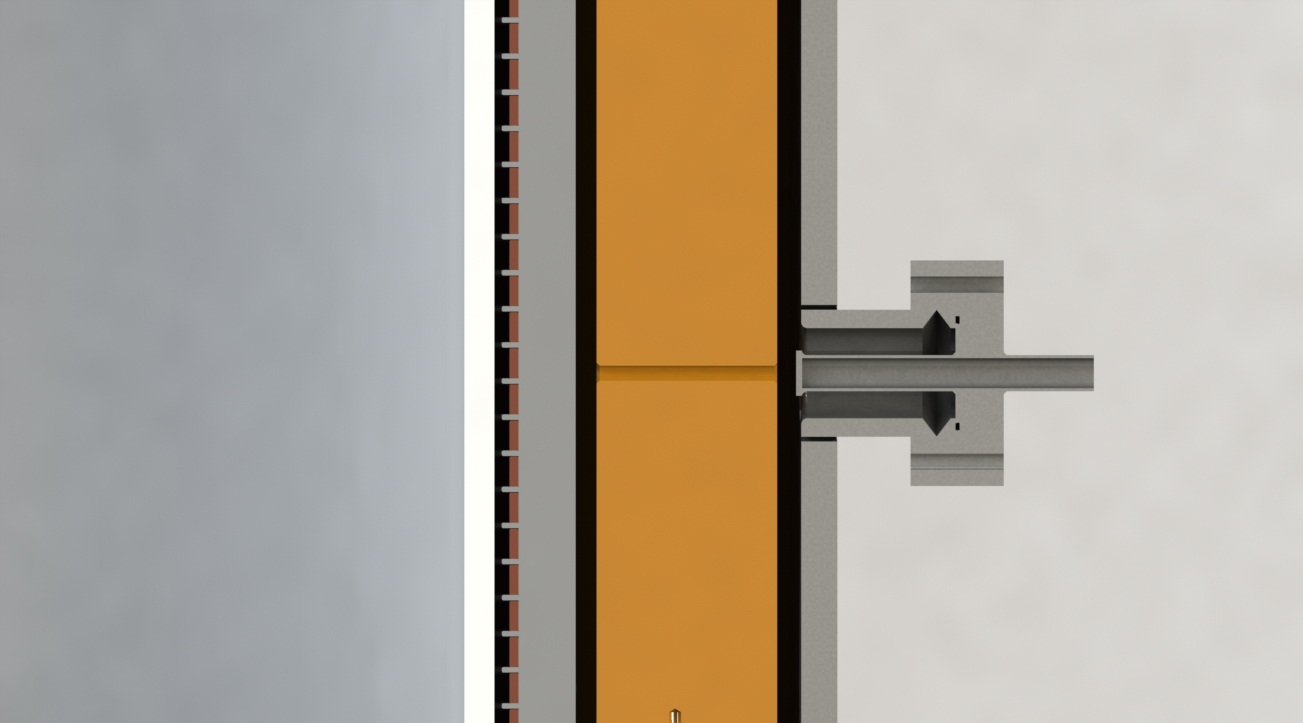

In [4]:
Image(filename='sourceport1.jpg') 

#### Lateral port 

The picture shows a cut of the lateral port, with the insert to locate the source. Notice the channel in the copper. The diameter of the channel is 5 mm and the distance between the insert and the end of the copper is 74 mm. 

In [38]:
d_cu = 5. * units.mm
l_cu = 74. * units.mm
r_cu = d_cu/2.
print('diameter of copper port = {} mm copper thickness = {} mm'.format(
    d_cu/units.mm, l_cu/units.mm))

diameter of copper port = 5.0 mm copper thickness = 74.0 mm


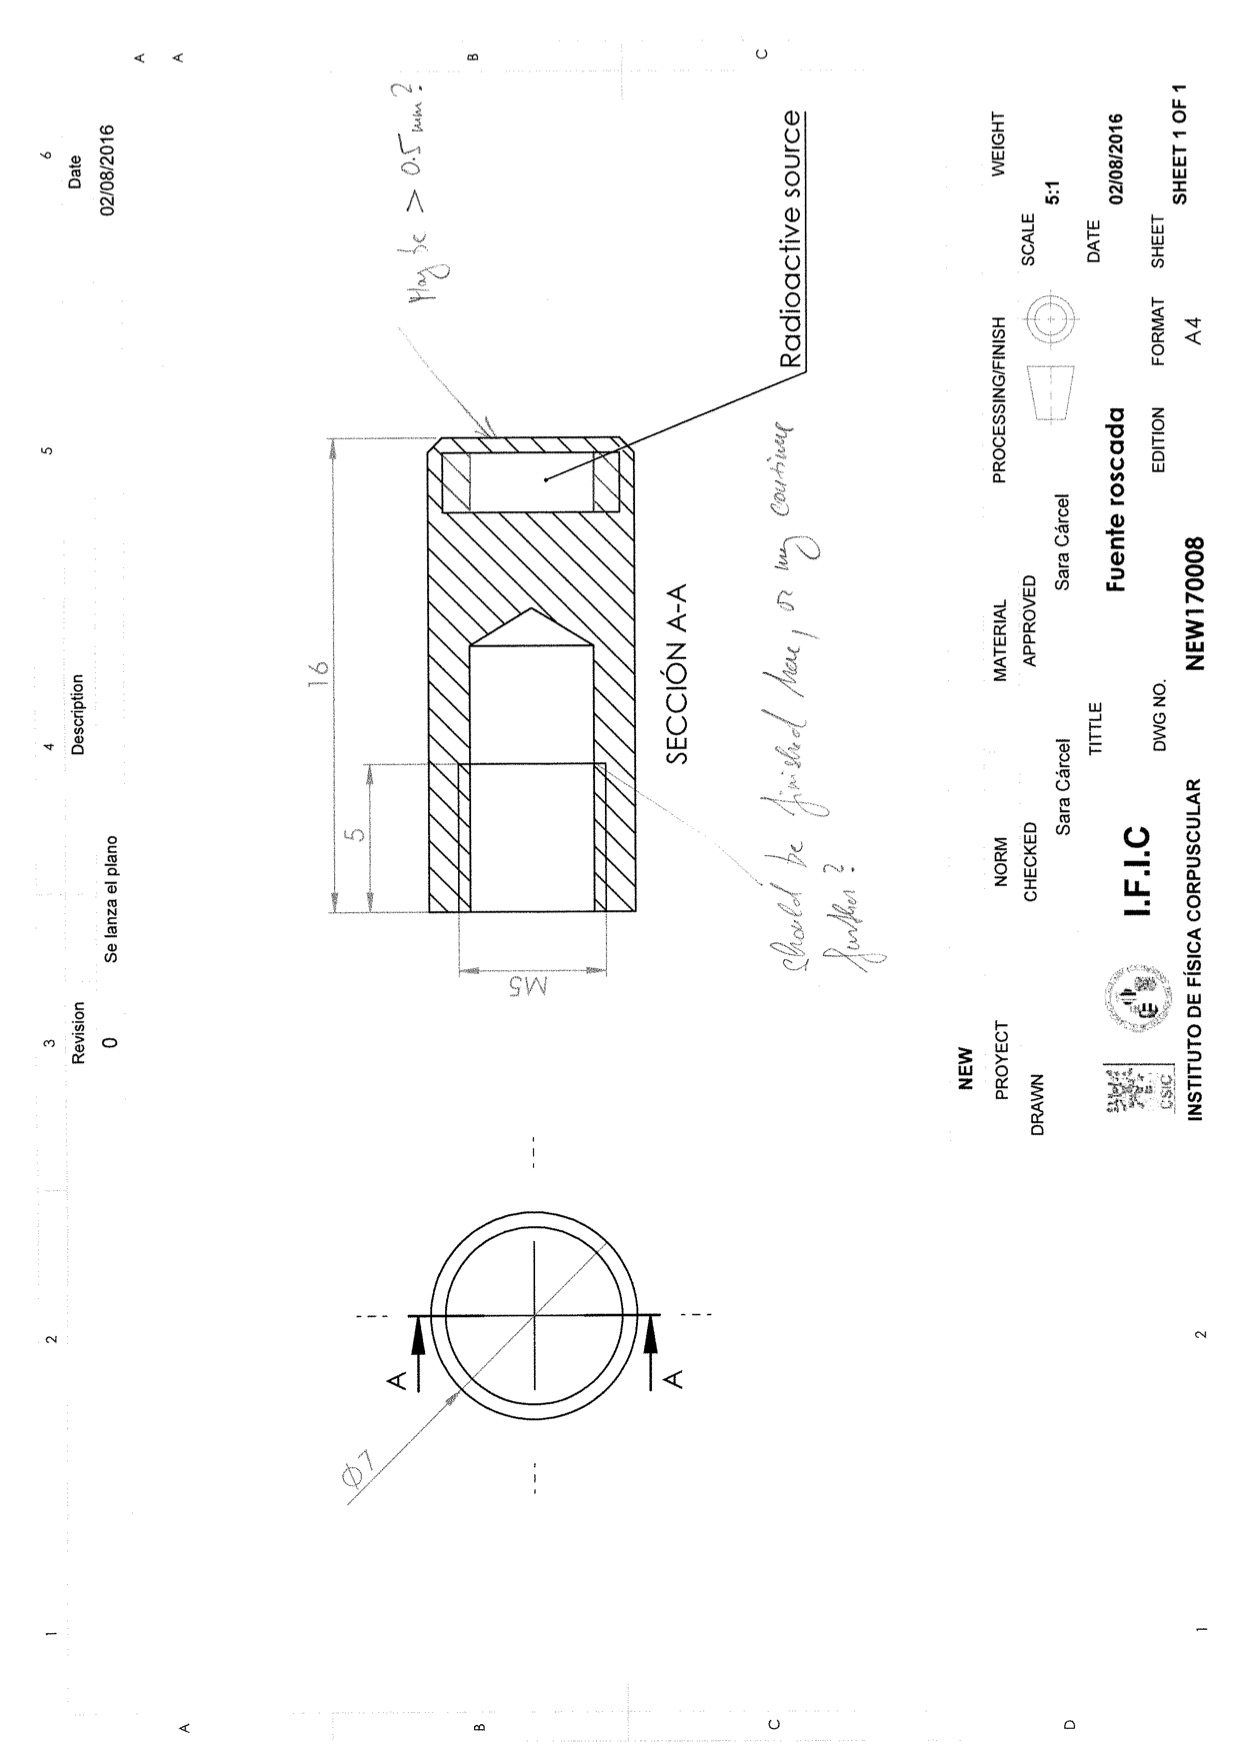

In [5]:
Image(filename='source.jpg') 

#### Source
The drawing shows the source itself. 

In [60]:
d_s = 7. * units.mm
l_s = 16. * units.mm
print('source is a cilinder of length = {} mm and diameter = {} mm'.format(
    l_s/units.mm, d_s/units.mm))

source is a cilinder of length = 16.0 mm and diameter = 7.0 mm


#### Distances: 
the distance between the source and the xenon gas (e.g, the distance that gammas need to travel to interact in the fiducial volume) is 104 mm. The insert tube has a length of 128 mm (e.g, the source can be displaced all the way up to 128 -16 mm pushing it up in the cylinder.

In [8]:
l_s_xe = 104. * units.mm
l_tube = 128.2 * units.mm
print('distance source to xenon volume = {} mm length of source holder = {} mm'.format(
    l_s_xe/units.mm, l_tube/units.mm))

distance source to xenon volume = 104.0 mm length of source holder = 128.2 mm


#### Opening angle:

The opening angle defines the number of gammas that interact in the gas. It is computed assuming that the source is point like in the center of the channel. 

In [66]:
%%latex
$\theta_c = \frac{1 - \cos(\phi)}{2}$
$\phi = \arctan(r/z)$

<IPython.core.display.Latex object>

#### Where:
1. r is the radius of the opening channel
2. z is the distance between the point of emission of the gammas and the gas volume. 

In [67]:
def opening_angle(r_cu, z_s):
    """
    Computes de opening angle for a source located at a distance z_s of the copper 
    r_cu is the radious of the copper channel
    """
    return (1. - np.cos(np.arctan(r_cu/z_s)))/2.

#### Attenuation in Xenon and Copper taken from NIST tables

In [42]:
attXe = pd.read_table('xe.txt',index_col=False)

In [43]:
attXe = pd.read_table('xe.txt',index_col=False)
attXe['Photoelectric'] = attXe['Photoelectric'] * units.cm2/units.g
attXe['Compton'] = attXe['Compton'] * units.cm2/units.g
attXe['Energy'] = attXe['Energy'] * units.MeV

In [44]:
attCu = pd.read_table('cu.txt',index_col=False)

In [45]:
attCu['Energy'] = attCu['Energy'] * units.MeV
attCu['Total'] = attCu['Total'] * units.cm2/units.g

In [46]:
class XeInt:
    """
    Computes the interaction of photons in xenon as a function of energy
    """
    
    def __init__(self, attXe, p):
        """
        Init takes an instance of attXe data frame and the pressure ssumed to be in bars, 
        e.g, do not multiply by units.
        """
        energy = attXe.Energy.values
        compton = attXe.Compton.values
        photo = attXe.Photoelectric.values
        
        self.fc = interpolate.interp1d(energy, compton)
        self.fp = interpolate.interp1d(energy, photo)
        
        self.xrho = XeRho()
        self.p = p
        self.rho = self.xrho.rho(self.p) 
        
    def lambda_compton(self, energy):
        """
        input: energy 
        returns: attenuation length for compton in units of distance^-1
        """
        return self.fc(energy) * self.rho  # (cm2/g) * (g/cm3) -> L^-1 
    
    def lambda_photo(self, energy):
        """
        input: energy 
        returns: attenuation length for photoelectric in units of distance^-1
        """
        return self.fp(energy) * self.rho  #interpolation units
    
    def transmitted_compton(self, energy, z):
        """
        transmitted beam after a distance z (only taking into account compton)
        """
        return np.exp(-self.lambda_compton(energy) * z)
    
    def transmitted_photo(self, energy, z):
        """
        transmitted beam after a distance z (only taking into account photo)
        """
        return np.exp(-self.lambda_photo(energy) * z)
    
    def int_compton(self, energy, z):
        """
        interaction fraction after a distance z (only taking into account compton)
        """
        return 1. - self.transmitted_compton(energy, z)
    
    def int_photo(self, energy, z):
        """
        interaction fraction after a distance z (only taking into account photo)
        """
        return 1. - self.transmitted_photo(energy, z)

    

In [47]:
class CuInt:
    """
    Computes the interaction of photons in Cu as a function of energy
    """
    
    def __init__(self, attCu, rho_cu = 8.92 * units.g/units.cm3):
        """
        Init takes an instance of attCu data frame
        """
        energy = attCu.Energy.values
        total = attCu.Total.values
        
        self.fc = interpolate.interp1d(energy, total)
        self.rho = rho_cu
        
    def lambda_total(self, energy):
        """
        input: energy 
        returns: attenuation length  in units of distance^-1
        """
        return self.fc(energy) * self.rho  # (cm2/g) * (g/cm3) -> L^-1 
    
    def transmitted_total(self, energy, z):
        """
        transmitted beam after a distance z 
        """
        return np.exp(-self.lambda_total(energy) * z)
    
    def int_total(self, energy, z):
        """
        interaction fraction after a distance z 
        """
        return 1. - self.transmitted_total(energy, z)
    
   
    

#### Xenon density
Xenon density as a function of pressure deviates slightly from perfect gas law

In [48]:
class XeRho:
    """
    Computes the density of xenon as a function of pressure
    """
    
    def __init__(self):
        x = np.array([1,5,10,20])
        y = np.array([5.290 * units.kg/units.m3,
                      27.01 * units.kg/units.m3,
                      55.55 * units.kg/units.m3,
                      118.36 * units.kg/units.m3])
        self.f = interpolate.interp1d(x, y)
        
    def rho(self, p):
        """
        input: pressure assumed to be in bars, e.g, do not multiply by units.
        returns: density in system of units (SOU)
        """
        return self.f(p)

In [54]:
xrho = XeRho()

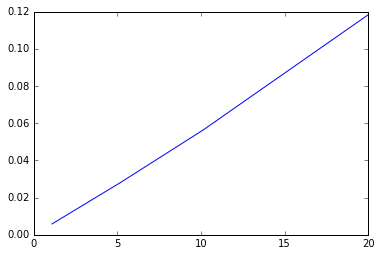

In [55]:
l =range(11,201)
y = np.array([xrho.rho(z/10.) for z in l])
p = np.array(l)/10.
rho = np.array(y) /(units.g/units.cm3)
plt.plot(p, rho)


In [56]:
for i in range(1,11):
    print('density at {} bar in g/cm3 = {}'.format(i, xrho.rho(i*1.)/(units.g/units.cm3)))

density at 1 bar in g/cm3 = 0.00529
density at 2 bar in g/cm3 = 0.01072
density at 3 bar in g/cm3 = 0.01615
density at 4 bar in g/cm3 = 0.02158
density at 5 bar in g/cm3 = 0.02701
density at 6 bar in g/cm3 = 0.032718
density at 7 bar in g/cm3 = 0.038426
density at 8 bar in g/cm3 = 0.044134
density at 9 bar in g/cm3 = 0.049842
density at 10 bar in g/cm3 = 0.05555


#### Activity of source:
1. Na-22 emits a positron which annihilates in 2 gammas of 511 keV and 1 gamma of 1275 keV.
2. Activity is defined as:

In [69]:
%%latex
$N_0 = \frac{N_\beta N_\gamma}{N_c}$

<IPython.core.display.Latex object>

##### Where:
1. N_beta refers to the number of beta decays (e.g, number of 2-back-to-back 511 keV gammas)
2. N_beta refers to the number of gamma decays (e.g, number of 1275 keV gammas)
3. N_c refers to the number of times both decays are registered in coincidence.

Assuming that each Na-22 decays results in one N_beta and one N_gamma (in reality N_beta is 90 % of the time, the rest is EC, but the correction is small), and that the decays are always registered in coincidence, then N_beta = N_gamma = N and N_0 = N.

Therefore the number of positrons is equal to the activity of the source. Each positron results in one gamma of 511 keV going in the direction of the detector (the other goes in the opposite direction). The number of gammas of 1275 keV is also equal to the activity of the source 

In [70]:
ActNaSource = 750  * units.kBq 

In [71]:
print('number of photons emitted by source per second = {}'.format(
       ActNaSource * units.second))

number of photons emitted by source per second = 750000.0


In [72]:
print('number of photons emitted by source in one DAQ window (1.2 ms) = {}'.format(
       ActNaSource* 1.2 * units.ms ))

number of photons emitted by source in one DAQ window (1.2 ms) = 900.0


In [77]:
theta_c = opening_angle(r_cu, l_cu)
print('opening angle with source nearest chamber (bottom of insert) = {} mili rads'.format(theta_c*1000))
print('nof of photons emitted per second within opening angle = {}'.format(ActNaSource * units.second * theta_c))
print('nof of photons emitted in 1.2 ms within opening angle = {}'.format(ActNaSource * 1.2 * units.ms * theta_c))

opening angle with source nearest chamber (bottom of insert) = 0.285091993848 mili rads
nof of photons emitted per second within opening angle = 213.818995386
nof of photons emitted in 1.2 ms within opening angle = 0.256582794463


### Attenuation in copper and in xenon

In [78]:
xatt = XeInt(attXe, 7.)  # at a pressure of 7 bar

In [58]:
xcu = CuInt(attCu)

### Gamma trasmission through a solid copper plug

In [59]:
x = range(1,101)
y = [xcu.transmitted_total(511 * units.keV, z * units.mm) for z in x]

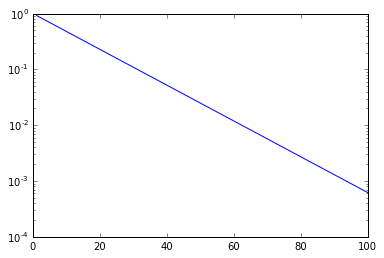

In [27]:
plt.semilogy(x,y)

In [28]:
print(' for rho = 7 bar, e = 511 keV, l_compton = {} cm^-1 , l_photo = {} cm^-1'.format(
       xatt.lambda_compton(511 * units.keV) * units.cm, xatt.lambda_photo(511 * units.keV) * units.cm))

print(' for l = 432 mm, e = 511 keV, t_compton = {}  t_photo = {} '.format(
       xatt.transmitted_compton(511 * units.keV, 432 * units.mm), 
       xatt.transmitted_photo(511 * units.keV, 432. * units.cm)))

print(' for l = 432, e = 511 keV, i_compton = {}  i_photo = {} '.format(
       xatt.int_compton(511 * units.keV, 432. * units.cm), 
       xatt.int_photo(511 * units.keV, 432. * units.cm)))

 for rho = 7 bar, e = 511 keV, l_compton = 0.002693066997 cm^-1 , l_photo = 0.00077063343 cm^-1
 for l = 432 mm, e = 511 keV, t_compton = 0.890172073199  t_photo = 0.716832095841 
 for l = 432, e = 511 keV, i_compton = 0.68757940644  i_photo = 0.283167904159 


### Interactions

#### the effective fiducial volume length for NEW is ~40 cm

In [82]:
L_tpc = 432 * units.mm

In [83]:
print('number of photoelectric interactions in one DAQ window (1.2 ms), 4 pi angle = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_photo(511 * units.keV, L_tpc)))

number of photoelectric interactions in one DAQ window (1.2 ms), 4 pi angle = 29.4689748793


In [84]:
print('number of compton interactions in one DAQ window (1.2 ms), 4 pi angle = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_compton(511 * units.keV, L_tpc)))

number of compton interactions in one DAQ window (1.2 ms), 4 pi angle = 98.8451341206


In [86]:
print('nof 511 keV photoelectric per second, theta_c, source at bottom = {}'.format(
       ActNaSource * units.second * xatt.int_photo(511 * units.keV,  L_tpc * theta_c )))
print('nof 511 keV compton per second, theta_c, source at bottom = {}'.format(
       ActNaSource * units.second * xatt.int_compton(511 * units.keV,  L_tpc * theta_c )))

nof 511 keV photoelectric per second, theta_c, source at bottom = 7.11829226288
nof 511 keV compton per second, theta_c, source at bottom = 24.875395075


In [87]:
print('nof 1275 keV photoelectric per second, theta_c, source at bottom = {}'.format(
       ActNaSource * units.second * xatt.int_photo(1275 * units.keV,  L_tpc * theta_c )))
print('nof 1275 keV compton per second, theta_c, source at bottom = {}'.format(
       ActNaSource * units.second * xatt.int_compton(1275 * units.keV,  L_tpc * theta_c )))

nof 1275 keV photoelectric per second, theta_c, source at bottom = 0.95936729777
nof 1275 keV compton per second, theta_c, source at bottom = 16.4083517795


In [88]:
print('nof 511 keV photoelectric (1.2 ms) within critical angle, source at bottom = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_photo(511 * units.keV,  L_tpc * theta_c )))
print('nof 511 keV compton (1.2 ms) within critical angle, source at bottom = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_compton(511 * units.keV,  L_tpc * theta_c )))
print('nof 1275 keV photoelectric (1.2 ms) within critical angle, source at bottom = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_photo(1275 * units.keV,  L_tpc * theta_c )))
print('nof 1275 keV compton (1.2 ms) within critical angle, source at bottom = {}'.format(
       ActNaSource* 1.2 * units.ms * xatt.int_compton(1275 * units.keV,  L_tpc * theta_c )))

nof 511 keV photoelectric (1.2 ms) within critical angle, source at bottom = 0.00854195071546
nof 511 keV compton (1.2 ms) within critical angle, source at bottom = 0.0298504740899
nof 1275 keV photoelectric (1.2 ms) within critical angle, source at bottom = 0.00115124075732
nof 1275 keV compton (1.2 ms) within critical angle, source at bottom = 0.0196900221354


#### NB: selecting on the photoelectric peak by trigger, it should be possible to avoid overlap with direct interactions from gammas. However, pileup due to compton electrons produced by gamma interactions in the copper is possible.

#### Colimation

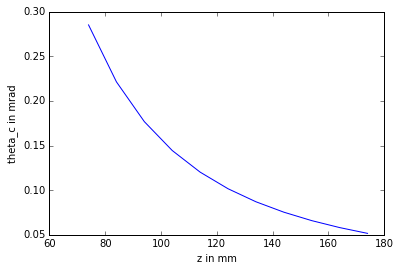

In [99]:
zs = np.array([l_cu + z * units.cm for z in range(11)])
theta_c = np.array([opening_angle(r_cu, z) for z in zs])
plt.plot(zs, theta_c * 1000)
plt.xlabel('z in mm')
plt.ylabel('theta_c in mrad')

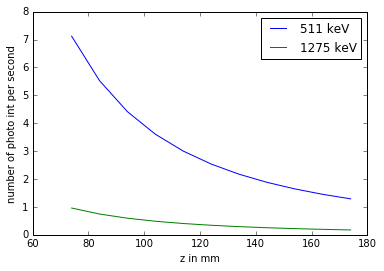

In [105]:
np511 = np.array([ ActNaSource * units.second * xatt.int_photo(511 * units.keV,  L_tpc * tc ) for tc in theta_c])
np1275 = np.array([ ActNaSource * units.second * xatt.int_photo(1275 * units.keV,  L_tpc * tc ) for tc in theta_c])
plt.plot(zs, np511, label='511 keV')
plt.plot(zs, np1275, label='1275 keV')
plt.xlabel('z in mm')
plt.ylabel('number of photo int per second')
plt.legend()

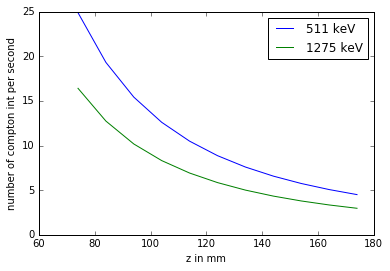

In [107]:
nc511 = np.array([ ActNaSource * units.second * xatt.int_compton(511 * units.keV,  L_tpc * tc ) for tc in theta_c])
nc1275 = np.array([ ActNaSource * units.second * xatt.int_compton(1275 * units.keV,  L_tpc * tc ) for tc in theta_c])
plt.plot(zs, nc511, label='511 keV')
plt.plot(zs, nc1275, label='1275 keV')
plt.xlabel('z in mm')
plt.ylabel('number of compton int per second')
plt.legend()